In [1]:
import random
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.datasets import make_regression
from scipy.stats import pearsonr

In [2]:
SAMPLES = 100
K = np.arange(0, 200)

In [3]:
np.random.seed(0)

In this notebook, I implement Ridge regression from scratch. This technique is applied to data that suffers from collinearity. Least squares estimates are unbiased in these situations, but due to collinearity we may end up having a very high variance that will in turn result in very low generalisation power.

In ridge regression, coefficients are estimated similarly to how it is done in the cse of least squares. The only difference is the addition of a bias term $k>0$:

$\hat{\beta}_{ridge}=(X^TX+kI)^{-1}X^TY$

This term artificially adds bias with the objective of decreasing variance and improve generalisation power. The coefficient values will shrink and tend to zero as we increase the value of $k$.

We have to take into account that data has to be standardised, and that there has to be a linear relationship in the data.

For the purposes of this notebook, I will be using `scikit-learn` to generate a toy dataset consisting of 6 features (and an intercept). Some of these features will be highly correlated:

In [4]:
(X, y, coef) = make_regression(n_samples = SAMPLES, 
                               n_features = 6, 
                               n_informative = 6, 
                               effective_rank = 2,
                               n_targets = 1, 
                               coef = True,
                               bias = 3,
                               tail_strength = 0)

These are the real coefficients (with intercept = 3) that were used to generate the dataset:

In [5]:
coef

array([47.93845494, 60.57119573, 63.74622774, 72.78881584, 81.19385617,
       11.56618719])

If we apply least squares, we can see that we can easily estimate the coefficients. This is not reflecting the real problem of having such a high collinearity in the input features. That will be demonstrated further below:

In [6]:
X = np.hstack((np.ones((SAMPLES, 1)), X))

In [7]:
print(np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y))

[ 3.         47.93845494 60.57119573 63.74622774 72.78881584 81.19385617
 11.56618719]


## Correlations visualisation

The following plot shows the relationship between each input variable and the output variable. This is just to demonstrate that there are not non-linear relationships in the data:

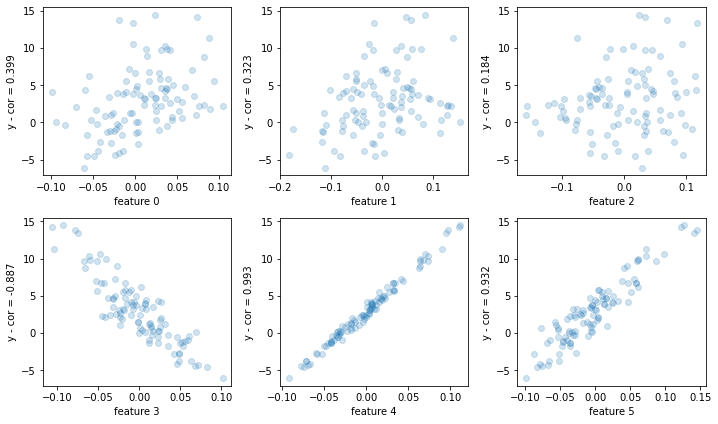

In [8]:
c = 3
r = (X.shape[1] - 1) // 3
_, ax = plt.subplots(r, c, figsize = (10, 6))
for i in range(X.shape[1] - 1):
    r = i // 3
    c = i % 3
    ax[r, c].scatter(X[:, i + 1], y, alpha = 0.2)
    ax[r, c].set_xlabel('feature ' + str(i))
    ax[r, c].set_ylabel('y - cor = %.3f' % pearsonr(X[:, i + 1], y)[0])
plt.tight_layout()

And the plot below shows the correlation between each pair of variables. This plot demonstrates the existence of colinearity in the data. 

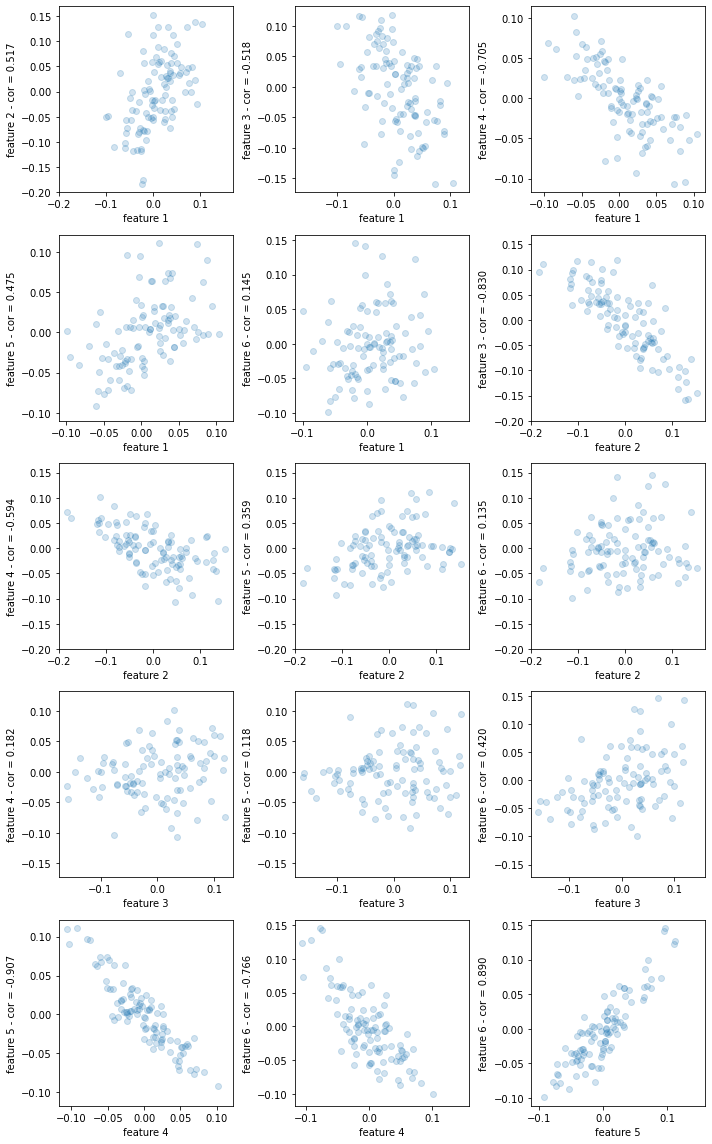

In [9]:
# Correlation between variables
comb = list(combinations(range(1, X.shape[1]), 2))
c = 3
r = len(comb) // 3
_, ax = plt.subplots(r, c, figsize = (10, 16))
for i, ind in enumerate(comb):
    r = i // 3
    c = i % 3
    ax[r, c].scatter(X[:, ind[0]], X[:, ind[1]], alpha = 0.2)
    ax[r, c].set_xlabel('feature ' + str(ind[0]))
    ax[r, c].set_ylabel('feature ' + str(ind[1]) + ' - cor = %.3f' % pearsonr(X[:, ind[0]], X[:, ind[1]])[0])
    ylim = ax[r, c].get_ylim()
    xlim = ax[r, c].get_xlim()
    min_lim = min(min(ylim), min(xlim))
    max_lim = max(max(ylim), max(xlim))
    ax[r, c].set_xlim(min_lim, max_lim)
    ax[r, c].set_ylim(min_lim, max_lim)
    #ax[r, c].set_aspect('equal', 'box')
plt.tight_layout()

## Ridge regression implementation



In [10]:
def normalise_data(X, mean = None, std = None):
    if mean is None or std is None:
        mean = np.mean(X[:, 1:], axis=0)
        std = np.std(X[:, 1:])
    x_t = np.copy(X)
    x_t[:, 1:] = (x_t[:, 1:] - mean) / std
    
    return x_t, mean, std

In [11]:
# Ridge regression implementation
def ridge_regression(k, X, y):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X) + k * np.identity(X.shape[1])), X.T), y)

In [12]:
def data_folds(X, k = 10):
    fold_size = int(len(X) / k)
    partitions = list(range(len(X)))
    random.shuffle(partitions)
    return np.array(partitions)[0:k * fold_size].reshape(k, fold_size)

## Hyperparameter selection

There's two ways in which we can select the value of the parameter $k$.

The traditional way consists of plotting a ridge trace plot, in which we can see the value of the coefficients as we increase the value of $k$. As mentioned at the top of this notebook, the coefficient values will tend to zero. We can choose the value of $k$ from which the ridge plot starts to look flat for each coefficient.

The second way is cross-validation. This is demonstrated above, but in this ridge trace plot we show the selected value of $k$ if we use cross-validation. If we had to set the value of $k$ by visually inspecting the ridge trace plot, we would surely have selected an even value of $k$ than cross-validation did. 

Therefore, the ridge trace plot may be interesting to understand which features correlate to each other, but a more formal approach should be used to select the value of $k$.

Text(0, 0.5, 'normalised coefficients')

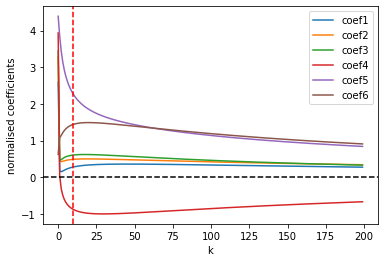

In [13]:
columns = []
for i in range(X.shape[1]):
    columns.append('coef' + str(i))
trace = pd.DataFrame(index = K, columns = columns)

X_s, _, _ = normalise_data(X)

for k in K:
    trace.loc[k] = ridge_regression(k, X_s, y)

fig, ax = plt.subplots()
for i in range(1, X.shape[1]):
    ax.plot(trace['coef' + str(i)])
plt.axhline(y=0, color='k', linestyle='--')
ax.legend(trace.columns[1:])
ax.axvline(x = 10, color = 'r', linestyle = '--')
ax.set_xlabel('k')
ax.set_ylabel('normalised coefficients')

The 10-fold cross-validation results are shown below. We can clearly see the effect of the bias parameter on improving the generalisation power and decreasing the test error. 

In [14]:
# Selecting k with close validation
folds = data_folds(X)
rmse_train_mean = []
rmse_train_std = []
rmse_test_mean = []
rmse_test_std = []
for k in K:
    rmse_train = []
    rmse_test = []
    for i in range(folds.shape[0]):
        x_test = X[folds[i, :], :]
        y_test = y[folds[i, :]]
        indexes = folds[[j for j in range(folds.shape[0]) if j!=i], :].flatten()
        x_train = X[indexes, :]
        y_train = y[indexes]
        
        x_train_s, mean, std = normalise_data(x_train)
        x_test_s, _, _ = normalise_data(x_test, mean, std)
        x_train_s = np.copy(x_train)
        coef = ridge_regression(k, x_train_s, y_train)
        
        rmse_train.append(np.power(np.sum(np.power(y_train - np.matmul(x_train_s, np.array(coef)), 2)), 0.5) / x_train_s.shape[0])
        rmse_test.append(np.power(np.sum(np.power(y_test - np.matmul(x_test_s, np.array(coef)), 2)), 0.5) / x_test_s.shape[0])
    rmse_train_mean.append(np.mean(rmse_train))
    rmse_train_std.append(np.std(rmse_train))
    rmse_test_mean.append(np.mean(rmse_test))
    rmse_test_std.append(np.std(rmse_test))
    
rmse_train_mean = np.array(rmse_train_mean)
rmse_train_std = np.array(rmse_train_std)
rmse_test_mean = np.array(rmse_test_mean)
rmse_test_std = np.array(rmse_test_std)

(0.0, 50.0)

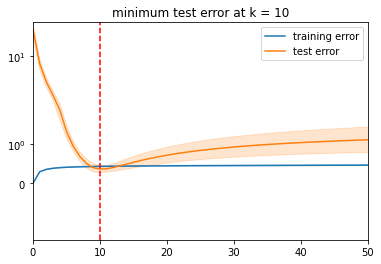

In [15]:
# Multiplying training variance times 100 to make it more visible
fig, ax = plt.subplots()
ax.plot(K, rmse_train_mean, color = 'C0')
ax.plot(K, rmse_test_mean, color = 'C1')
ax.fill_between(K, rmse_train_mean - rmse_train_std, rmse_train_mean + rmse_train_std, color = 'C0', alpha = 0.2)
ax.fill_between(K, rmse_test_mean - rmse_test_std, rmse_test_mean + rmse_test_std, color = 'C1', alpha = 0.2)
min_error = K[np.argmin(rmse_test_mean)]
ax.axvline(x = min_error, color = 'r', linestyle = '--')
ax.set_title('minimum test error at k = ' + str(min_error))
ax.legend(['training error', 'test error'])
ax.set_yscale('symlog')
ax.set_xlim([0, 50])